In [ ]:
model_path = "output/models/watermelon_GAN_GENERATOR_E_384_COMPARISON_watermelon_without_GAN_and_plain_phase_loss.pth"
model_path = "output/models/watermelon_GAN_GENERATOR_E_384_COMPARISON_watermelon_without_GAN_without_modulation.pth"
model_path = "output/models/watermelon_GAN_GENERATOR_E_384_COMPARISON_watermelon_without_GAN_without_perceptual_loss.pth"
model_path = (
    "output/models/watermelon_GAN_GENERATOR_E_384_COMPARISON_watermelon_without_GAN.pth"
)
model_path = "output/models/watermelon_GAN_GENERATOR_E_384_COMPARISON_epoch4.pth"
model_path = "output/models/watermelon_GAN_GENERATOR_E_384_COMPARISON_epoch5.pth"


validate_amp = "data/MIT_CGH_384_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_384_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_384_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_384_bin/validate/depth.bin"

import torch
from learnedMethodForHologram import utilities

from learnedMethodForHologram.watermelon_hologram.data_loader import (
    dataloaderImgDepthAmpPhs as data_loader,
)
from learnedMethodForHologram.watermelon_hologram.generator import Generator

from learnedMethodForHologram.angular_spectrum_method import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

from learnedMethodForHologram.watermelon_hologram.watermelon import (
    watermelon as watermelon,
)

dataset_test = data_loader(
    img_path=validate_img,
    depth_path=validate_depth,
    amp_path=validate_amp,
    phs_path=validate_phs,
    samplesNum=100,
    channlesNum=3,
    height=384,
    width=384,
    cuda=True,
)

dataLoader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

watermelon_holo = watermelon(
    filter_radius_coefficient=0.5,
    pad_size=320,
    kernel_size=3,
    distance_stack=torch.linspace(-1.5e-4, 0.0, 8)[:-1],
    pretrained_model_path_G=model_path,
    pretrained_model_path_D=None,
    input_shape=(1, 4, 384, 384),
    cuda=True,
)

model = watermelon_holo.generator.eval()

propagator = BLASM_v3(
    sample_row_num=384,
    sample_col_num=384,
    pad_size=320,
    filter_radius_coefficient=0.45,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=True,
    distance=torch.tensor([1e-3]),
)

with torch.no_grad():
    img_depth, amp, phs = next(iter(dataLoader_test))
    POH = model(img_depth)
    amp_hat, _ = propagator.propagate_POH2AP_forward(POH)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(
        torch.cat((img_depth[:, :-1], amp, amp_hat, phs, _ % (2 * torch.pi)), dim=0)
    ),
    titles=["img", "amp", "amp_hat", "phs", "phs_hat"],
    rgb_img=True,
    # save_dir="output\\images\\GAN\\10",
)

In [ ]:
from learnedMethodForHologram.angular_spectrum_method import (
    bandLimitedAngularSpectrumMethod_for_multiple_distances as BLASM_v4,
)

propagator_test = BLASM_v4(
    # sample_row_num=192,
    # sample_col_num=192,
    # pad_size=416,
    sample_row_num=384,
    sample_col_num=384,
    pad_size=832,
    distances=torch.linspace(-1.5e-4, 1.5e-4, 1),
    filter_radius_coefficient=0.45,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=True,
)

amp_ones = torch.ones_like(POH).to("cuda")
amp_hat, phs_hat = propagator_test(amp_ones, POH, torch.linspace(1e-3 - 6e-4, 1e-3, 30))
amp_target, phs_target = propagator_test(
    amp, 2 * torch.pi * phs, torch.linspace(-6e-4, 0, 30)
)


utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_hat),
    titles=None,
    rgb_img=True,
    save_dir="output\\images\\GAN\\watermelon_with_GAN_epoch5_amp",
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_target),
    titles=None,
    rgb_img=True,
    save_dir="output\\images\\GAN\\watermelon_with_GAN_epoch5_amp_target",
)

# utilities.multi_sample_plotter(
#     ((phs_hat + 20 * torch.pi) % (2 * torch.pi)) / (2 * torch.pi),
#     titles=None,
#     rgb_img=True,
#     save_dir="output\\images\\GAN\\E_384_epoch8_phs_hat",
# )

# utilities.multi_sample_plotter(
#     (phs_target + 20 * torch.pi) % (2 * torch.pi) / (2 * torch.pi),
#     titles=None,
#     rgb_img=True,
#     save_dir="output\\images\\GAN\\E_384_epoch8_phs_target",
# )

utilities.multi_sample_plotter(
    (POH + 20 * torch.pi) % (2 * torch.pi) / (2 * torch.pi),
    titles=None,
    rgb_img=True,
    # save_dir="output\\images\\GAN\\E_384_epoch8_POH",
)

# print(model.part2.part1.conv_r.params[model.part2.part1.conv_r.distance_map])
# print(model.part2.part1.conv_g.params[model.part2.part1.conv_g.distance_map])
# print(model.part2.part1.conv_b.params[model.part2.part1.conv_b.distance_map])

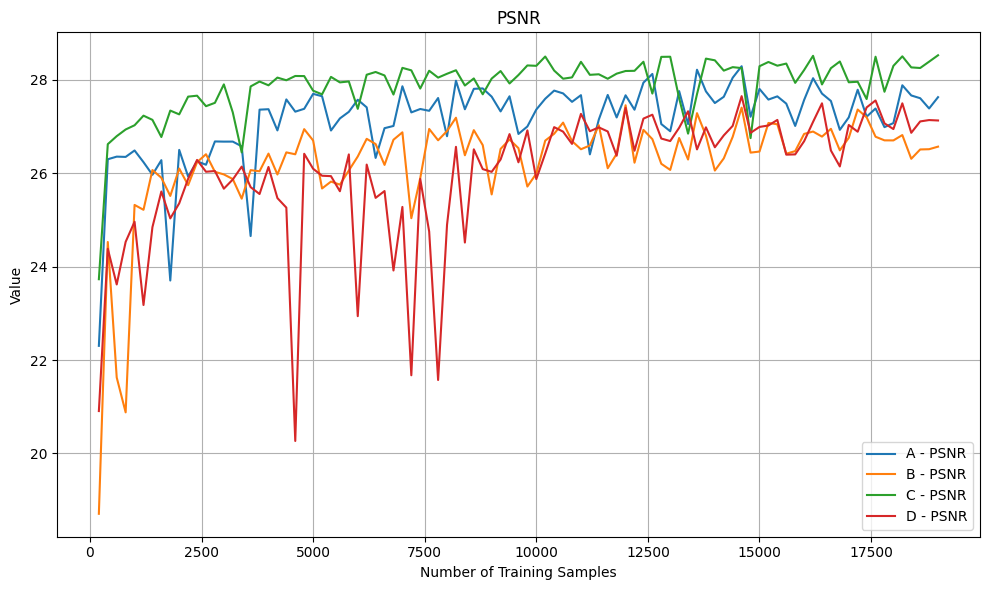

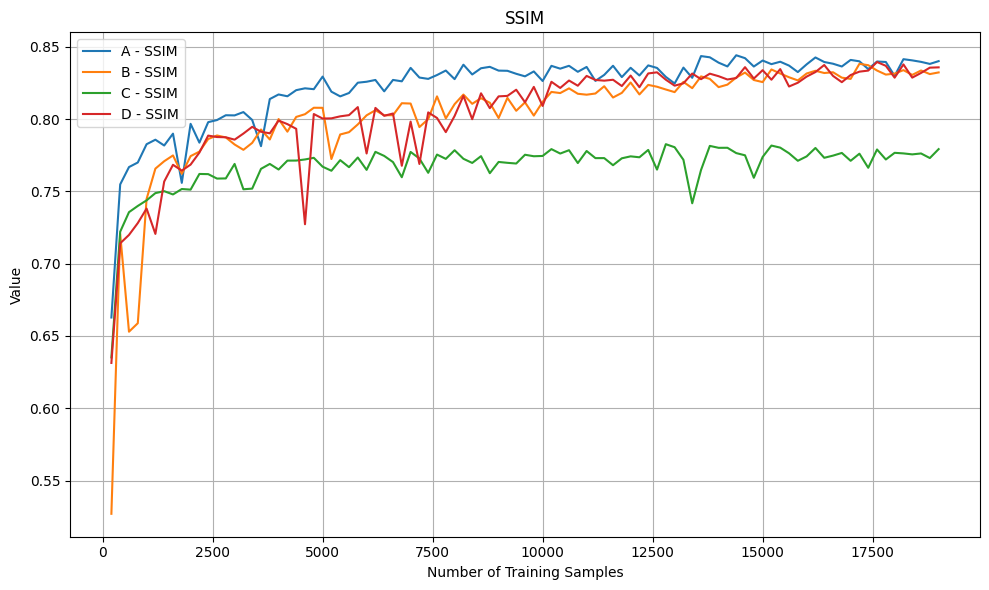

In [2]:
without_GAN_and_plain_phase_loss = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_and_plain_phase_loss.json"
without_GAN_without_modulation = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_without_modulation.json"
without_GAN_without_perceptual_loss = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_without_perceptual_loss.json"
without_GAN = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN.json"
GAN = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON.json"
GAN_epoch5 = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON (1).json"


from learnedMethodForHologram.utilities import training_process_visualizer

training_process_visualizer(
    json_files=[
        without_GAN,
        without_GAN_and_plain_phase_loss,
        without_GAN_without_perceptual_loss,
        without_GAN_without_modulation,
        # GAN,
        # GAN_epoch5,
    ],
    metrics=["validate_metrics_tensor/PSNR"],
    # metrics=["train_metrics_tensor/PSNR", "validate_metrics_tensor/SSIM"],
    output_file="output/images/validate_PSNR.png",
    labels=["A", "B", "C", "D"],
)

training_process_visualizer(
    json_files=[
        without_GAN,
        without_GAN_and_plain_phase_loss,
        without_GAN_without_perceptual_loss,
        without_GAN_without_modulation,
        # GAN,
        # GAN_epoch5,
    ],
    metrics=["validate_metrics_tensor/SSIM"],
    # metrics=["train_metrics_tensor/PSNR", "validate_metrics_tensor/SSIM"],
    output_file="output/images/validate_SSIM.png",
    labels=["A", "B", "C", "D"],
)

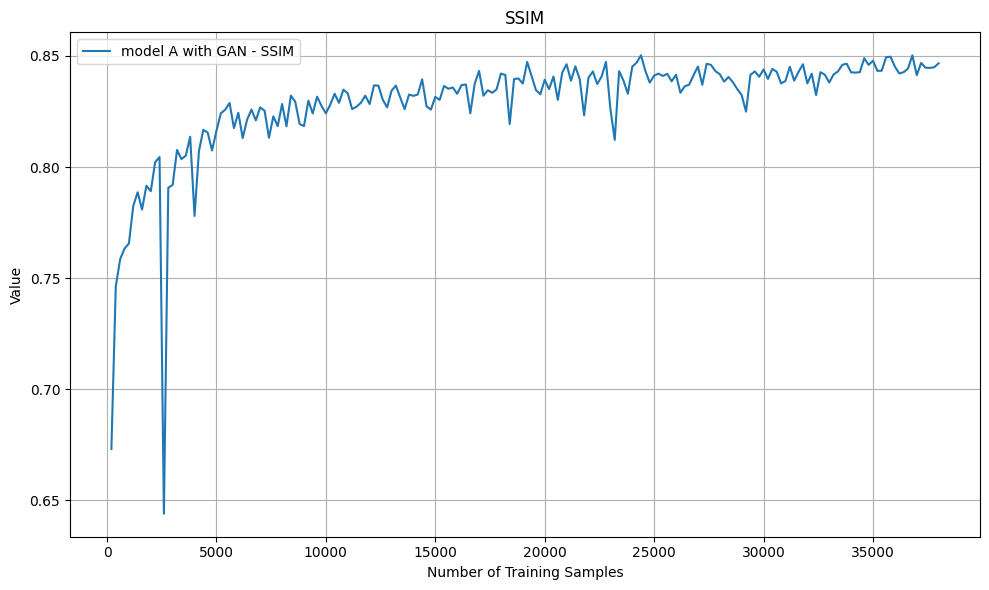

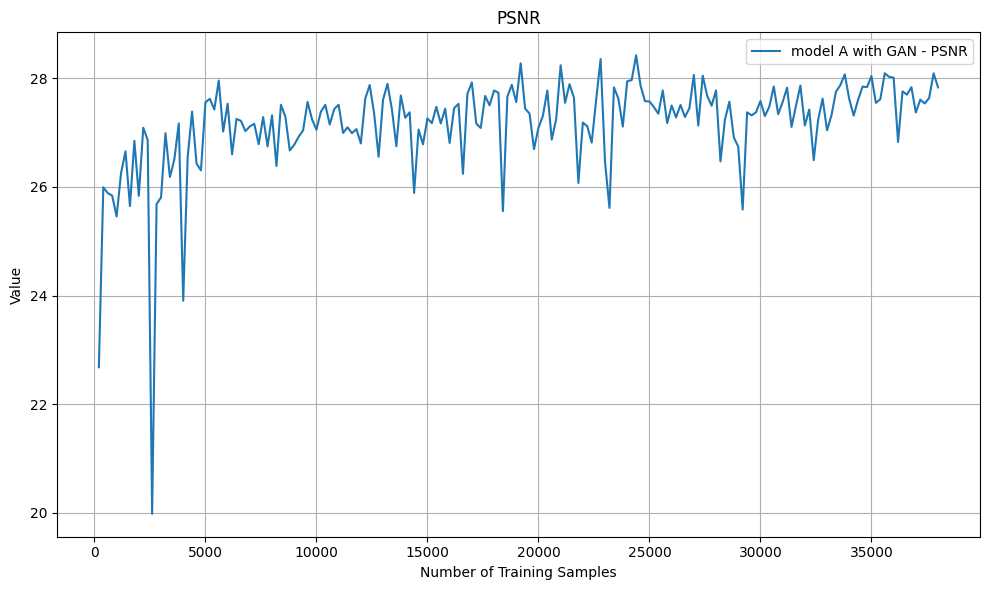

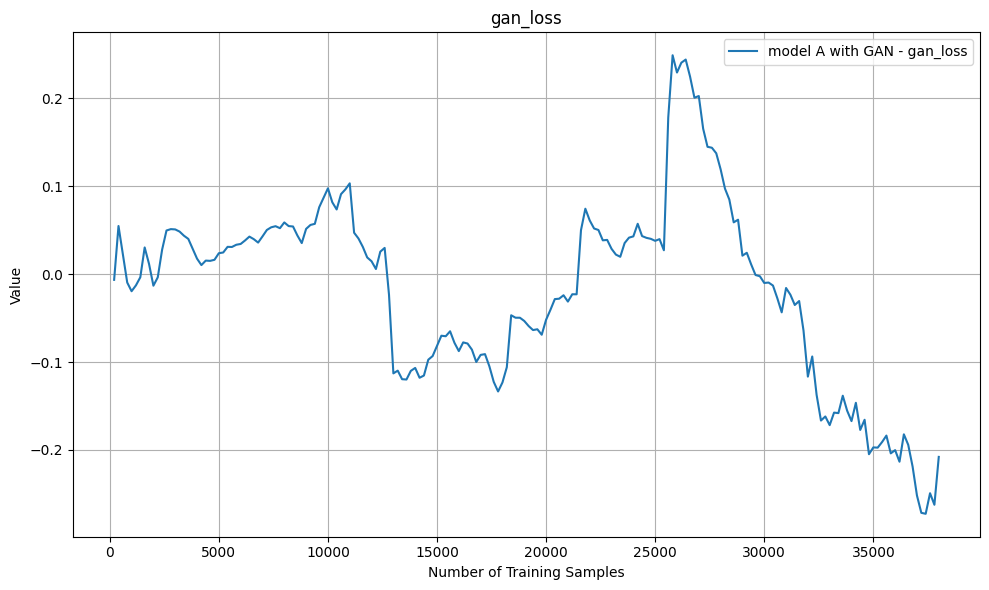

In [5]:
without_GAN_and_plain_phase_loss = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_and_plain_phase_loss.json"
without_GAN_without_modulation = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_without_modulation.json"
without_GAN_without_perceptual_loss = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_without_perceptual_loss.json"
without_GAN = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN.json"
GAN = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON (2).json"
GAN_epoch5 = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON (1).json"


from learnedMethodForHologram.utilities import training_process_visualizer

training_process_visualizer(
    json_files=[
        GAN,
        # GAN_epoch5
    ],
    metrics=["validate_metrics_tensor/SSIM"],
    output_file="output/images/DGLoss.png",
    labels=["model A with GAN"],
)

training_process_visualizer(
    json_files=[
        GAN,
        # GAN_epoch5
    ],
    metrics=["validate_metrics_tensor/PSNR"],
    output_file="output/images/DGLoss.png",
    labels=["model A with GAN"],
)

training_process_visualizer(
    json_files=[
        GAN,
        # GAN_epoch5
    ],
    metrics=["train_losses_tensor/gan_loss"],
    output_file="output/images/DGLoss.png",
    labels=["model A with GAN"],
)

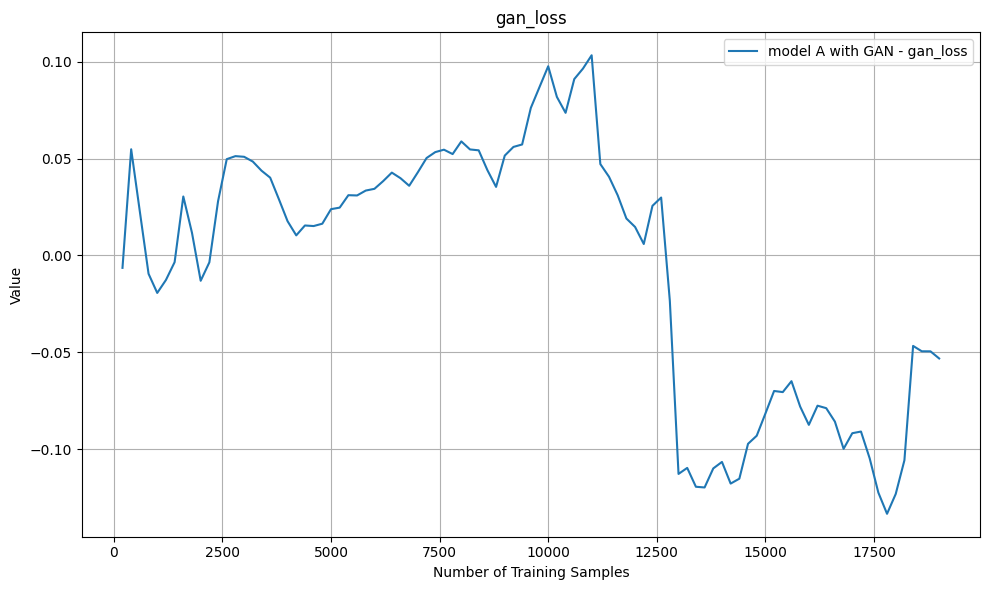

In [3]:
without_GAN_and_plain_phase_loss = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_and_plain_phase_loss.json"
without_GAN_without_modulation = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_without_modulation.json"
without_GAN_without_perceptual_loss = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_without_perceptual_loss.json"
without_GAN = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN.json"
GAN = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON.json"
GAN_epoch5 = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON (1).json"


from learnedMethodForHologram.utilities import training_process_visualizer

training_process_visualizer(
    json_files=[
        GAN,
        # GAN_epoch5
    ],
    metrics=["train_losses_tensor/gan_loss"],
    output_file="output/images/DGLoss.png",
    labels=["model A with GAN"],
)

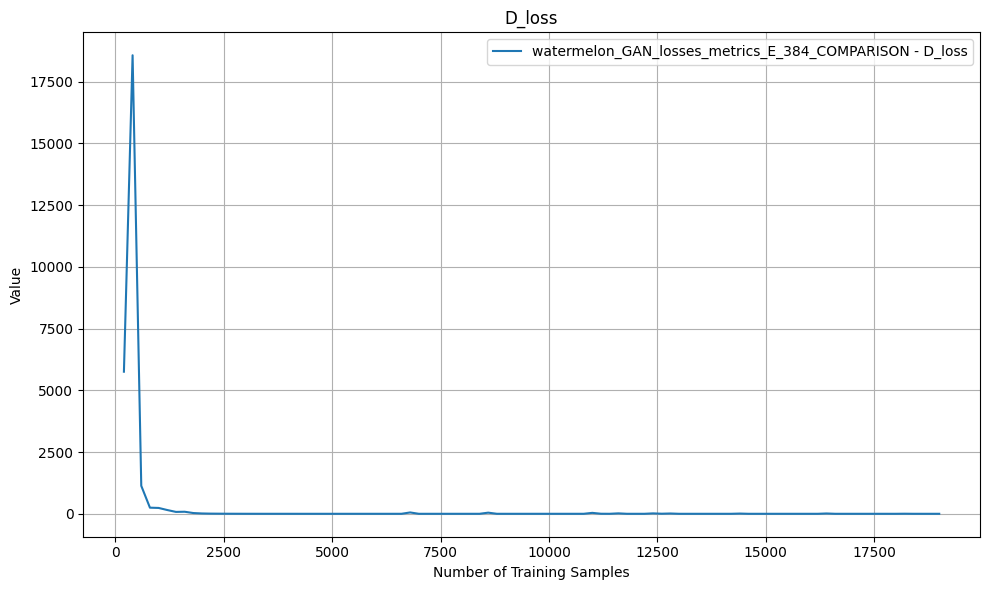

In [1]:
without_GAN_and_plain_phase_loss = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_and_plain_phase_loss.json"
without_GAN_without_modulation = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_without_modulation.json"
without_GAN_without_perceptual_loss = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN_without_perceptual_loss.json"
without_GAN = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON_watermelon_without_GAN.json"
GAN = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON.json"
GAN_epoch5 = "output/data/watermelon_GAN_losses_metrics_E_384_COMPARISON (1).json"

from learnedMethodForHologram.utilities import training_process_visualizer

training_process_visualizer(
    json_files=[
        GAN,
        # GAN_epoch5
    ],
    metrics=["train_losses_tensor/D_loss"],
    output_file="output/images/DGLoss.png",
)

In [ ]:
import torch

from learnedMethodForHologram.angular_spectrum_method import (
    bandLimitedAngularSpectrumMethod_for_multiple_distances as BLASM_v4,
)

from learnedMethodForHologram import utilities

propagator_test = BLASM_v4(
    sample_row_num=2400,
    sample_col_num=4094,
    pad_size=1200,
    distances=torch.linspace(-1.5e-4, 1.5e-4, 1),
    filter_radius_coefficient=0.45,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=False,
)

POH = 2 * torch.pi * torch.load("output/data/usaf1951_POH.pt").to("cpu")
amp_ones = torch.ones_like(POH)
amp_hat = propagator_test(amp_ones, POH, torch.linspace(1e-3 - 6e-4, 1e-3, 5))

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_hat),
    titles=None,
    rgb_img=True,
    save_dir="output\\images\\GAN\\usaf1951_POH_amp",
)

Generator loaded from output/models/watermelon_GAN_GENERATOR_E_384_COMPARISON.pth


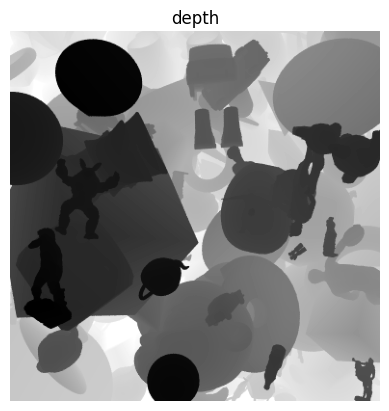

<Figure size 640x480 with 0 Axes>

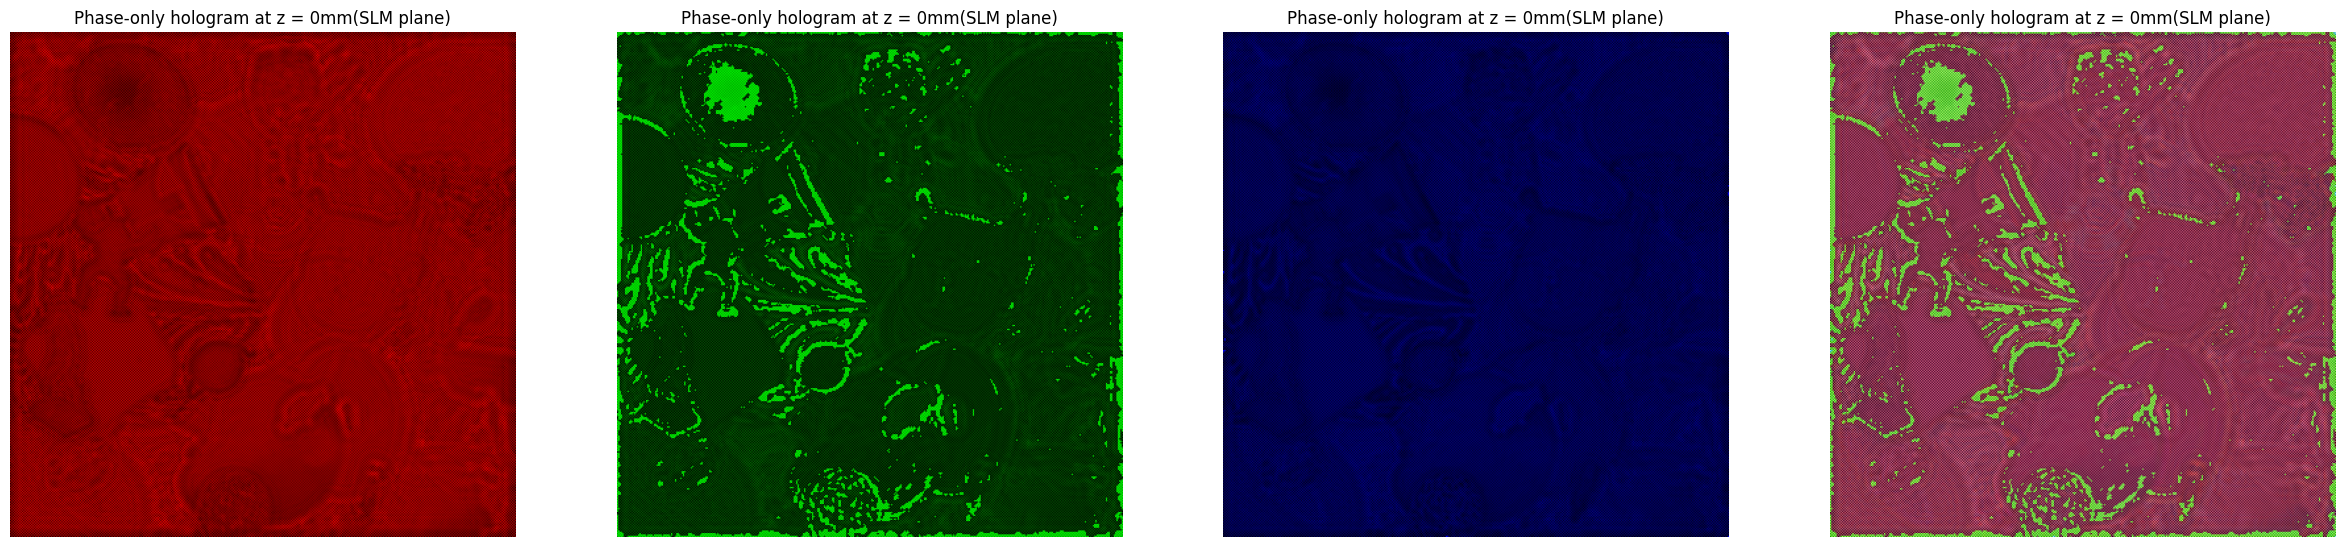

In [5]:
import torch

from learnedMethodForHologram.angular_spectrum_method import (
    bandLimitedAngularSpectrumMethod_for_multiple_distances as BLASM_v4,
)

propagator_test = BLASM_v4(
    sample_row_num=384,
    sample_col_num=384,
    pad_size=832,
    distances=torch.linspace(-1.5e-4, 1.5e-4, 1),
    filter_radius_coefficient=0.35,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=True,
)

test_amp = "data/MIT_CGH_384_bin/test/amp.bin"
test_phs = "data/MIT_CGH_384_bin/test/phs.bin"
test_img = "data/MIT_CGH_384_bin/test/img.bin"
test_depth = "data/MIT_CGH_384_bin/test/depth.bin"

model_path = "output/models/watermelon_GAN_GENERATOR_E_384_COMPARISON.pth"

from learnedMethodForHologram.watermelon_hologram.watermelon import (
    watermelon as watermelon,
)

from learnedMethodForHologram.watermelon_hologram.data_loader import (
    dataloaderImgDepthAmpPhs as data_loader,
)

from learnedMethodForHologram import utilities

GAN_model = watermelon(
    filter_radius_coefficient=0.45,
    pad_size=320,
    distance_stack=torch.linspace(-4e-4, 0.0, 2)[
        :-1
    ],  # distance_stack=torch.linspace(-1.2e-4, 0.0, 20)[:-1],
    pretrained_model_path_G=model_path,
    pretrained_model_path_D=None,
    input_shape=(1, 4, 384, 384),
    cuda=True,
)

GAN_model.generator.eval()

dataset_test = data_loader(
    img_path=test_img,
    depth_path=test_depth,
    amp_path=test_amp,
    phs_path=test_phs,
    samplesNum=100,
    channlesNum=3,
    height=384,
    width=384,
    cuda=True,
)

with torch.no_grad():
    # read RGBD from dataset
    RGBD = dataset_test[0][0].unsqueeze(0)

    # generate POH
    POH = GAN_model.generator(RGBD)
    amp_ones = torch.ones_like(POH).to("cuda")

    # propagate POH
    amp_hat = propagator_test(
        amp_ones, POH, torch.linspace(1e-3 - 6e-4, 1e-3, 30)
    )

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(RGBD[:, :-1]),
    titles=["RGB"],
    rgb_img=True,
    save_dir="output\\images\\GAN\\watermelon_with_GAN_amp",
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(RGBD[:, -1:]),
    titles=["depth"],
    rgb_img=True,
    save_dir="output\\images\\GAN",
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(POH),
    titles=["Phase-only hologram at z = 0mm(SLM plane)"],
    rgb_img=True,
    # save_dir="output\\images\\GAN\\watermelon_with_GAN_POH",
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_hat),
    titles=[f"z = {distance:.2}mm" for distance in 1000 * torch.linspace(1e-3 - 6e-4, 1e-3, 30)],
    rgb_img=True,
    # save_dir="output\\images\\GAN\\watermelon_with_GAN",
)

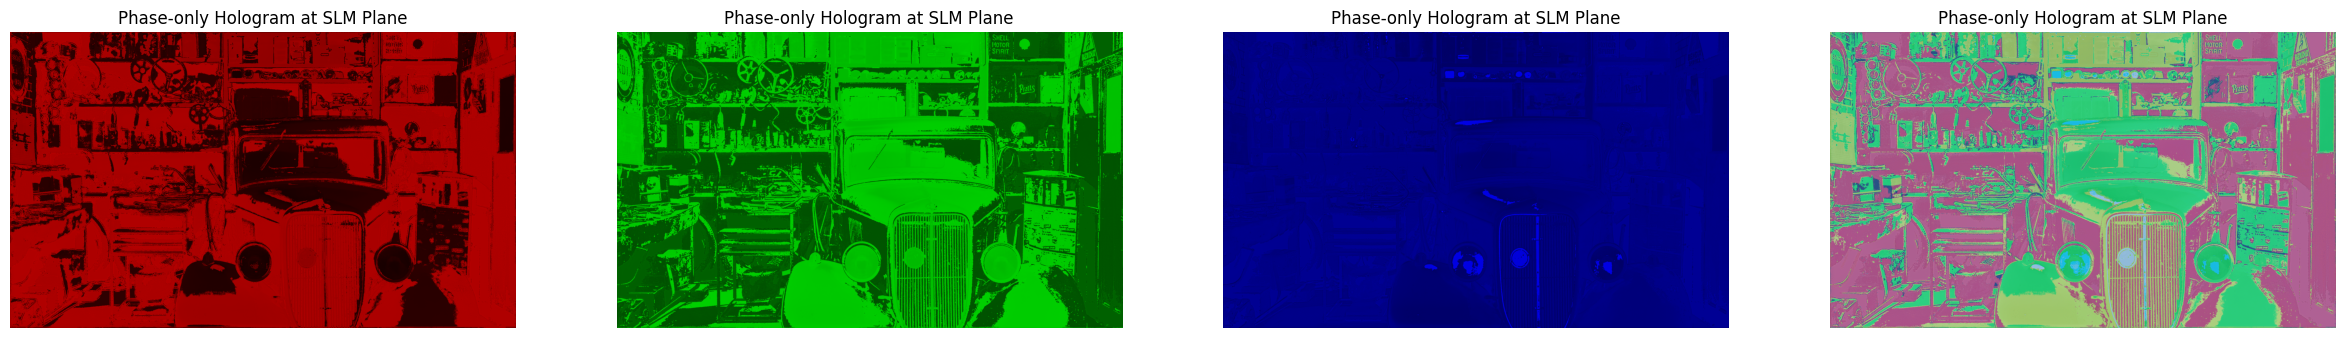

In [6]:
import torch
from learnedMethodForHologram import utilities
POH = torch.load("output/data/0900_POH.pt").to("cpu")
utilities.multi_sample_plotter(
    POH,
    titles=["Phase-only Hologram at SLM Plane"],
    rgb_img=True,
    # save_dir="output\\images\\GAN\\0900_POH",
)

(2400, 4094, 3)


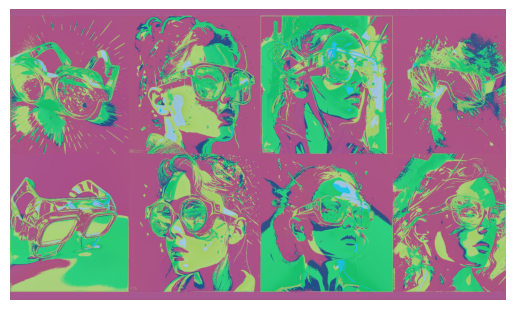

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

POH = torch.load("output/data/holographic_glasses_POH.pt").to("cpu").squeeze().permute(1, 2, 0).numpy()

print(POH.shape)

plt.imshow(POH)
plt.axis('off')
plt.show()

plt.imsave("output/images/POH.png", POH)
